<img src="https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png" alt="InvertedAI" width="200"/>


In [3]:
import sys
sys.path.insert(0, "..")

import IPython
from IPython.display import display, Image, clear_output
from ipywidgets import interact

import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2 
import invertedai as iai
from IPython.utils import io
import time

In [4]:
# API key:
iai.add_apikey("WyiIbfxsbPak3HpP2JVNma7jfQQIrflxa4AUS6mC")

In [5]:
# pick a location (4 way, signalized intgersection)
location = "iai:drake_street_and_pacific_blvd"

In [6]:
location_info_response = iai.location_info(location=location)
rendered_static_map = location_info_response.birdview_image.decode()
scene_plotter = iai.utils.ScenePlotter(rendered_static_map, 
                                       location_info_response.map_fov, 
                                       (location_info_response.map_center.x, location_info_response.map_center.y), 
                                       location_info_response.static_actors)

In [7]:
collisions = None

# Simulate with `initialize`, `drive` and `light` until there are collisions.
while collisions is None:
    light_response = iai.light(location=location)

    response = iai.initialize(
        location=location,  
        agent_count=15,    
        get_birdview=True,  
        traffic_light_state_history=[light_response.traffic_lights_states]  
    )
    agent_attributes = response.agent_attributes  
    scene_plotter.initialize_recording(response.agent_states, 
                                       agent_attributes=agent_attributes, 
                                       traffic_light_states=light_response.traffic_lights_states)

    agent_state_history = []
    traffic_light_state_history = []

    # 20-second scene
    for _ in range(100):  
        light_response = iai.light(location=location, recurrent_states=light_response.recurrent_states)
        response = iai.drive(
            location=location,
            agent_attributes=agent_attributes,
            agent_states=response.agent_states,
            recurrent_states=response.recurrent_states,
            get_birdview=False,
            traffic_lights_states=light_response.traffic_lights_states,
            get_infractions=False,
            random_seed=1
        )
        scene_plotter.record_step(response.agent_states, traffic_light_states=light_response.traffic_lights_states)
        agent_state_history.append(response.agent_states)
        traffic_light_state_history.append(light_response.traffic_lights_states)
        
        print(f"Iteration number {_}")
        clear_output(wait=True)
    
    
    blame_response = iai.blame(
        location=location,
        candidate_agents=[0, 0],
        agent_state_history=agent_state_history,
        agent_attributes=agent_attributes,
        traffic_light_state_history=traffic_light_state_history,
        get_birdviews=False,
        detect_collisions=True
    )
    collisions = blame_response.blamed_collisions
    print(collisions)
    

print(collisions)

[((0, 11), (41, 74), (0,))]
[((0, 11), (41, 74), (0,))]


In [8]:
agent_state_history

[[AgentState(center=Point(x=38.0, y=6.67), orientation=0.39, speed=11.65),
  AgentState(center=Point(x=16.72, y=12.04), orientation=-2.81, speed=1.22),
  AgentState(center=Point(x=28.05, y=13.63), orientation=-2.74, speed=2.01),
  AgentState(center=Point(x=-47.59, y=-15.27), orientation=-2.77, speed=12.82),
  AgentState(center=Point(x=-40.37, y=-16.16), orientation=-2.76, speed=10.56),
  AgentState(center=Point(x=17.6, y=-21.44), orientation=-0.85, speed=0.32),
  AgentState(center=Point(x=42.81, y=22.38), orientation=-2.77, speed=8.74),
  AgentState(center=Point(x=27.36, y=16.0), orientation=-2.76, speed=6.38),
  AgentState(center=Point(x=-3.44, y=8.33), orientation=2.08, speed=6.33),
  AgentState(center=Point(x=20.01, y=9.52), orientation=-2.76, speed=0.03),
  AgentState(center=Point(x=-25.19, y=-22.26), orientation=0.41, speed=8.49),
  AgentState(center=Point(x=31.53, y=0.99), orientation=0.38, speed=11.52),
  AgentState(center=Point(x=28.12, y=-23.08), orientation=2.29, speed=3.07),

In [9]:
# %%capture
# gif_name = 'iai-drive-side-road-green.gif'
# fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 15))
# scene_plotter.animate_scene(output_name=gif_name, ax=ax,
#                             numbers=False, direction_vec=False, velocity_vec=False,
#                             plot_frame_number=True)

In [10]:
# Image(gif_name)

In [11]:
idx = 0
collision = collisions[idx]
blame_response = iai.blame(
    location=location,
    candidate_agents=collision[0],
    agent_state_history=agent_state_history[:collision[1][0]],
    traffic_light_state_history=traffic_light_state_history[:collision[1][0]],
    agent_attributes=agent_attributes,
    get_reasons=True,
    get_confidence_score=True,
    get_birdviews=False,
    detect_collisions=False
)
print(blame_response.blamed_result)

(0,)


In [12]:
blame_response.reasons

{0: ['rear_end']}

In [13]:
blame_response.confidence_score

0.4680720865726471

In [14]:
%%capture
fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 15))
gif_name = 'part-iai-drive-side-road-green.gif'
scene_plotter.animate_scene(output_name=gif_name, ax=ax, 
                            start_idx=max(0, collision[1][0] - 50), end_idx=collision[1][1],
                            numbers=list(collision[0]), direction_vec=False, velocity_vec=False,
                            plot_frame_number=True)

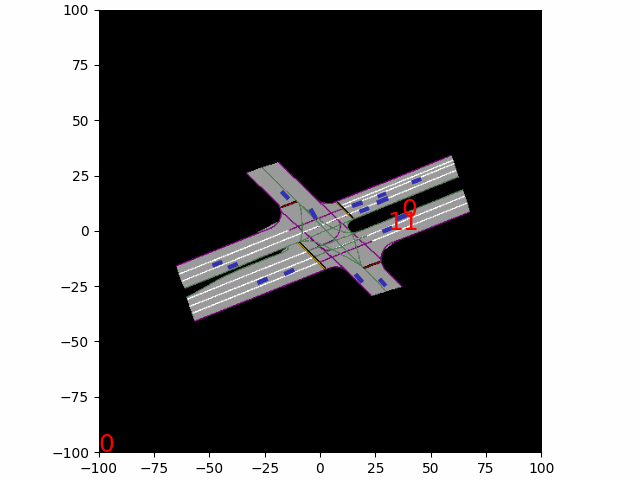

In [15]:
Image(gif_name)